<h1><font style = "color:blue"> Calculating posterior distributions and modal estimates in Markov mixture models </font></h1>

* P matrice de transition
* n matrice des nombre de transitions
* a premier paramètre de l'a priori gamma sur les lambda
* b second paramètre de l'a priori gamma sur les lambda
* S liste des états
* lambda  paramètres de la Poisson
* alpha premier paramètre du gamma sur les $P_{i,j}$
* Y les observations

The states are simulated according to :
 
 $p(s_t/Y_n, S^{t+1}, \theta) \propto p(s_t/Y_t, \theta) \times p(s_{t+1}/ s_t, \theta)$
 
 * Estimate  $ p(s_t/Y_t, \theta)$:
     * Predict
     * Update
 * Estimate $p(s_{t+1}/ s_t, \theta)$ via a Gamma prior
 
And, finally, simulate the states starting from the last one : $s_n$

# Outline

- Simulate S/Y, $\theta$, P
- Simulate P/Y, $\theta$, S
- Simuler $\theta$/Y,S,P  
==> Restart until Nmax

In [1]:
import pandas as pd, numpy as np, scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

# Simulate theta

In [2]:
def get_lambda(Y, S, a, b): # Simulate lambda_prior given the observations and states
    u = np.bincount(S, weights= Y)
    v = np.bincount(S)
    return stats.gamma.rvs(a = a+u, scale = 1/(b + v))

In [3]:
# Some tests
Y = np.array([1]*10)
S = np.array([0,1]*5) # Just two states: O or 1
a = np.array([1,2]) # First gamma prior parameter
b = np.array([2, 1]) # Second gamma prior parameter

get_lambda(Y, S,a, b)

array([1.03183819, 0.68491331])

# Simulate P

In [4]:
def get_P(S, alpha, rep = 1): # rep : simulate several or just one Dirichlet ?
    n = np.zeros(alpha.shape)
    tab = pd.crosstab(S[:-1], S[1:]) # transitions' count
    n[ :len(tab), tab.columns] = tab.values
    a = alpha + n
    g2 = 0
    for i in range(rep):
        g = stats.gamma(a = a).rvs()
        g = g/g.sum(1)[:, None]
        g2 = (i*g2 + g)/(i+1)
    return  g2

In [5]:
# Some tests
S = np.array([0, 1]*5) # two states : 0 or 1
alpha = np.array([[1, 1], [1, 1]]) 
get_P(S, alpha)

array([[0.18806365, 0.81193635],
       [0.75371082, 0.24628918]])

# SImulate S

In [6]:
def _init(P): # Compute the left eigenvector assocated with the eigenvalue 1
    eigval, eigvect = sp.linalg.eig(P, left = True, right=  False)
    p = eigvect[:, eigval.real.round(3) == 1.].reshape(-1)
    p = p/p.sum()
    return p

In [7]:
def poisson(y, _lambda): # Poisson cdf
    return np.power(_lambda, y)*np.exp(-_lambda)/sp.special.factorial(y)

def poisson2(y, _lambda): # Poisson cdf
    return stats.poisson.pmf(y, _lambda)

In [8]:
def get_S(Y, theta, P, f): # Simulate the states
    n = len(Y)
    m = len(P)
    
    F = np.zeros((n, m))
    
    v = f(Y[0], theta)
    F[0] = _init(P)*v
    F[0] = F[0]/F[0].sum()
    for i in range(1, n):
        v = f(Y[i], theta)
        F[i] = (F[i-1]@P)*v
        F[i] = F[i]/F[i].sum()
    
    S = np.zeros(n, dtype = int)
    a = np.arange(m)
    p = F[-1]
    S[-1] = np.random.choice(a = a , p = p/p.sum())    
    
    for i in range(n-2, 0, -1):
        p = F[i]*P[:, S[i+1]]
        S[i] = np.random.choice(a = a , p = p/p.sum())
        
    return F, S

In [9]:
# Some tests

In [10]:
P = np.array([[0.1,0.9],[0.9,0.1]])
y = np.array([1,5,3, 7, 4, 8, 3, 1,2, 4])
_lambda = np.array([1, 5])

F,S = get_S(y, _lambda, P, poisson)
F.round(2), S

(array([[0.92, 0.08],
        [0.  , 1.  ],
        [0.79, 0.21],
        [0.  , 1.  ],
        [0.44, 0.56],
        [0.  , 1.  ],
        [0.8 , 0.2 ],
        [0.8 , 0.2 ],
        [0.44, 0.56],
        [0.1 , 0.9 ]]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

# Gibbs sampler

In [11]:
def gibbs(S0,f,Y, alpha, a, b , T): # The final gibbs sampler, starts form a given S0
    L = {"theta":[], "S": [] }
    for t in range(T):
        theta = get_lambda(Y,S0, a,b)
        P = get_P(S0, alpha)
        F,S = get_S(Y, theta, P, f)
        S0 = S
        L["theta"].append(theta)
        L["S"].append(S)
    return L

# We're gonna test our gibbs sampler on an artificial data

In [12]:
def simul_poisson(P, lambda_, size = 10): # Simulate an artificial poisson MMM
    y = []
    m = len(lambda_)
    s = np.random.choice(m)
    for t in range(size):
        y.append(stats.poisson.rvs(mu = lambda_[s]))
        s = np.random.choice(m, p = P[s])
    return y

In [13]:
P0 = np.array([[0.67, 0.33], [0.45, 0.55]])
theta0 = np.array([1., 10])

(array([76.,  4., 11., 14., 17., 14.,  8.,  4.,  1.,  1.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

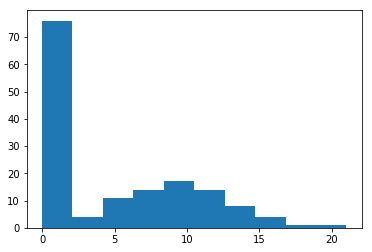

In [14]:
y = simul_poisson(P0, theta0, size = 150)
plt.hist(y)

# Can gibbs sampler recover the underlying  model ?

In [15]:
n = len(y)
alpha = np.array([[0.75, 0.25], [0.5,0.5]])
a = np.array([1, 2])
b = np.array([2, 1])
S0 = np.random.choice(2, n)
S0[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [16]:
L = gibbs(S0, poisson,y, alpha, a, b, T = 300)
L["S"][-1], L["theta"][-1]

(array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]),
 array([9.21957203, 0.87576762]))

In [17]:
np.array(L["theta"][100:]).mean(0) # Not so bad, isn't it  ?

array([9.40571042, 0.9655602 ])

In [18]:
get_P(L["S"][-3], alpha) # Almost !

array([[0.53644112, 0.46355888],
       [0.3349842 , 0.6650158 ]])

# On a real dataset :  the 'lamb' dataset

In [19]:
df = pd.read_csv("lamb.csv")
df.head()

,id,x
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [20]:
n = len(df)
y = df.x.values
alpha = np.array([[3, 1], [0.5,0.5]])
a = np.array([1, 2])
b = np.array([2, 1])
S0 = np.random.choice(2, n)
S0[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

In [21]:
L = gibbs(S0, poisson,y, alpha, a, b, T = 500)
L["S"][-1], L["theta"][-1]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.20653175, 2.11306656]))

In [22]:
np.array(L["theta"][100:]).mean(0) # Quite the same result as in the paper

array([0.21667636, 2.24325407])

In [23]:
np.array([get_P(SS , alpha) for SS in L["S"][100:]]).mean(0) # Yeaah !

array([[0.96418229, 0.03581771],
       [0.33368305, 0.66631695]])

In [24]:
np.bincount(np.array(L["S"][-1]))

array([219,  21])